This notebook performs hierarchical bootstraps and plots place field characteristics such as stability, reliability, field height, width, # fields, etc.

### NRK NOTE
Try scaling figures by 75%

In [11]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pingouin as pg

from neuropy import plotting
from neuropy.core.epoch import Epoch
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired, bootstrap_resample

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define sessions

In [2]:
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info

In [3]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette("muted", as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])
cmap3 = cmap3[0:4]
cmap3

['#4878D0', '#A1C9F4', '#EE854A', '#FFB482']

## Load in group data

In [4]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = group_data_dir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7


### Define useful functions

In [7]:
from copy import deepcopy
def trim_unreliable_neurons(df_in):
    """Trims out neurons that aren't active in BOTH MAZE and reMAZE"""

    df_trim_comb = []
    for animal in df_in.animal.unique():
        df_animal = df_in[df_in.animal == animal]
        for day in df_animal.day.unique():
            df_use = df_animal[df_animal.day == day]
            maze_ids = df_use[df_use.session == "reMAZE"].cell_id.unique()
            remaze_ids = df_use[df_use.session == "MAZE"].cell_id.unique()
            maze_same = [np.isin(mid, remaze_ids) for mid in maze_ids]
            same_ids = maze_ids[maze_same]

            df_trim_temp = deepcopy(df_use)
            df_trim_comb.append(df_trim_temp[np.isin(df_trim_temp.cell_id, same_ids)])

    return pd.concat(df_trim_comb, axis=0, ignore_index=True)

df_use = trim_unreliable_neurons(stats_all_df[stats_all_df.grp == "NSD"])
df_use

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,7,0,3.000000,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,7,1,0.700000,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,7,2,0.500000,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,9,0,0.300000,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,9,1,0.300000,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,160,2,5.972617,0.9,42.958763,1.635617,41.987615,43.623233,0.775781,0.196877,10.367705,10.090055,down,reMAZE,RatV,Day3,NSD,2
2269,160,3,4.772617,0.4,3.668676,1.453369,2.921031,4.374399,0.775781,0.196877,10.367705,10.090055,down,reMAZE,RatV,Day3,NSD,2
2270,166,0,1.500000,1.5,4.602286,2.846570,3.230378,6.076949,0.778247,0.057950,1.553642,0.562323,down,reMAZE,RatV,Day3,NSD,2
2271,166,1,0.300000,0.3,17.200281,5.004943,14.359379,19.364322,0.778247,0.057950,1.553642,0.562323,down,reMAZE,RatV,Day3,NSD,2


## Reliability and stability

### Bootstrap reliability and stability

In [16]:
stats_all_peak = stats_all_df[stats_all_df.peak_no == 0]
df_rs = stats_all_df.pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                 columns="session", 
                                 values="r_odd_even").reset_index().drop(columns=["cell_id", "direction"]).reset_index()
df_rs.rename(columns={"sid": "session"})

session,index,grp,session,MAZE,reMAZE
0,0,NSD,0,-0.142335,0.951700
1,1,NSD,0,-0.150833,0.617885
2,2,NSD,0,0.040590,NaN
3,3,NSD,0,0.747352,0.854094
4,4,NSD,0,0.629554,0.865368
...,...,...,...,...,...
859,859,SD,7,0.864541,0.478741
860,860,SD,7,0.303631,0.280133
861,861,SD,7,0.681525,0.367422
862,862,SD,7,0.764482,-0.112693


In [17]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean(numeric_only=True).reset_index()
df_bs_all = []
for metric, sesh_type_drop, sesh_type_keep in zip(["r_odd_even", "r_maze_remaze"], ["reMAZE", "MAZE"],
                                                  ["MAZE", "NA"]):
    print(metric)
    df_use = stats_all_peak.pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                        columns="session", 
                                        values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})
    
    # if metric == "r_maze_remaze":
    #     df_use = df_use.drop(columns="reMAZE")
    df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
    df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
    df_bs["metric"] = metric
    df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
    df_bs_all.append(df_bs)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_stability_reliability_bootstrap.csv")
df_bs

r_odd_even
Running bootstraps for NSD group


100%|████████████████████████████████████████| 10000/10000 [00:13<00:00, 746.43it/s]


Running bootstraps for SD group


100%|████████████████████████████████████████| 10000/10000 [00:18<00:00, 549.75it/s]


r_maze_remaze
Running bootstraps for NSD group


100%|████████████████████████████████████████| 10000/10000 [00:14<00:00, 713.57it/s]


Running bootstraps for SD group


100%|████████████████████████████████████████| 10000/10000 [00:18<00:00, 537.55it/s]


,grp,session,r_odd_even,metric,r_maze_remaze
0,NSD,MAZE,0.560223,r_odd_even,NaN
1,NSD,MAZE,0.666839,r_odd_even,NaN
2,NSD,MAZE,0.641170,r_odd_even,NaN
3,NSD,MAZE,0.540100,r_odd_even,NaN
4,NSD,MAZE,0.537349,r_odd_even,NaN
...,...,...,...,...,...
59995,SD,MAZE,NaN,r_maze_remaze,0.232849
59996,SD,MAZE,NaN,r_maze_remaze,0.242130
59997,SD,MAZE,NaN,r_maze_remaze,0.246366
59998,SD,MAZE,NaN,r_maze_remaze,0.283602


### Plot reliability and stability

/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

NSD vs. SD: get_bootstrap_prob, P_val:1.748e-01 Stat=1.258e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:2.739e-01 Stat=2.917e-02


/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:1.900e-02 Stat=1.655e-01


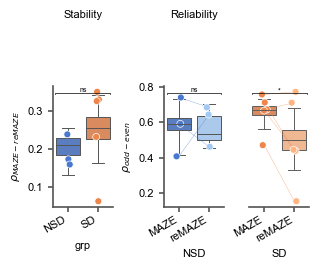

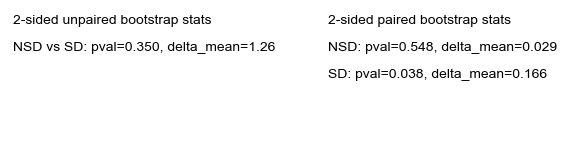

In [18]:
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired
fig = Fig(16, 12)
figs = Fig(16, 12)

df2_mean = stats_all_peak.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# Stability NSD vs. SD
# ax, axstat = axs.T[0]
axs = []
ax = fig.subplot(fig.gs[0:2, 0])
axstat = figs.subplot(figs.gs[2:4, 0])
axs.append(axstat)

# sns.boxplot(data=df_bs, y="r_maze_remaze", hue="grp", whis=(2.5, 97.5), showfliers=False, legend=False, palette=cmap3[::2], ax=ax)
# sns.stripplot(data=df2_mean, y="r_maze_remaze", hue="grp", edgecolor="w", dodge=True, linewidth=0.5, palette=cmap3[::2], legend=False, ax=ax)
p1 = Plotter(data=df_bs, x="grp", y="r_maze_remaze", ax=ax)
p1.boxplot_remaze(palette=cmap3[::2], zorder=3, sep=1.2).stat_anot_remaze(
    stat_within=get_bootstrap_prob,
    alpha_within=[0.025, 0.005, 0.0005],
    alpha_trend=0.05,
    compare_var="grp",
    compare_vals=["NSD", "SD"],
    fontsize=5,
    verbose=True,
)
p2 = Plotter(data=df2_mean[df2_mean.session == "MAZE"], x="grp", y="r_maze_remaze", ax=ax)
p2.striplineplot_remaze(palette=cmap3[::2], grp_offset=0, dodge=0, lineplot=False)

ax.set_title("Stability")
ax.set_ylabel(r"$\rho_{MAZE-reMAZE}$")
sns.despine(ax=ax)

axstat.text(0.1, 0.9, "2-sided unpaired bootstrap stats")
sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == "r_maze_remaze"]
dmean, pval = get_bootstrap_prob(df_trim[df_trim.grp == "NSD"]["r_maze_remaze"], df_trim[df_trim.grp == "SD"]["r_maze_remaze"])
axstat.text(0.1, yt, f"NSD vs SD: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
axstat.set_xticks([])
axstat.set_yticks([])

# Reliability NSD vs. SD
# ax, axstat = axs.T[1]

# for ida, (axuse, grp) in enumerate(zip(axs.T[1:], ["NSD", "SD"])):
axrel = []
results_list = []
for ida, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[0:2, ida + 1])
    axrel.append(ax)
    axstat = figs.subplot(figs.gs[2:4, ida + 1])
    axs.append(axstat)
    
    df_grp = df_bs[df_bs.grp == grp]
    # sns.boxplot(data=df_grp, y="r_odd_even", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
    #             palette=cmap3[ida*2:], ax=ax)
    p1 = Plotter(data=df_grp, x="session", y="r_odd_even", ax=ax)
    results_list.append(p1.boxplot_remaze(palette=cmap3[ida*2:(ida+1)*2], zorder=3, sep=1.2).stat_anot_remaze(
                stat_within=get_bootstrap_prob_paired,
                alpha_within=[0.025, 0.005, 0.0005],
                alpha_trend=0.05,
                fontsize=5,
                verbose=True,
                prepend=("reliability", grp),
            ))
    
    # sns.stripplot(data=df2_mean[df2_mean.grp == grp], y="r_odd_even", hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
    #               palette=cmap3[ida*2:], ax=ax)
    # sns.lineplot(data=df2_mean[df2_mean.grp == grp], x="session", y="r_odd_even", hue="session", units="sid", estimator=None, legend=False,
    #               palette=cmap3[ida*2:], lw=0.25, alpha=0.8, ax=ax)
    p2 = Plotter(data=df2_mean[df2_mean.grp == grp], x="session", y="r_odd_even", ax=ax)
    p2.striplineplot_remaze(palette=cmap3[ida*2:(ida+1)*2], grp_offset=0, dodge=0, units="sid")
    
    if ida == 0:
        ax.set_title("Reliability")
        ax.set_ylabel(r"$\rho_{odd-even}$")
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    # ax.set_xticks([0])
    ax.set_xlabel(grp)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
yt = 0.7
df_trim = df_bs[df_bs.metric == "r_odd_even"]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"]["r_odd_even"], 
                                            df_grp[df_grp.session == "reMAZE"]["r_odd_even"])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.3f}")
    yt -= 0.2
    
[sns.despine(ax=a, left=True, bottom=True) for a in axs];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1].set_axis_off()
axrel[0].set_ylim(axrel[1].get_ylim())

fig.savefig(plot_dir / "PF_stability_reliability_bs.pdf")

## Peak Firing Rate

### Peak field bootstrap

Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 773.08it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 579.13it/s]


,grp,session,height,metric
0,NSD,MAZE,4.617725,height
1,NSD,MAZE,5.154315,height
2,NSD,MAZE,4.682882,height
3,NSD,MAZE,3.471720,height
4,NSD,MAZE,4.940982,height
...,...,...,...,...
39995,SD,reMAZE,9.066817,height
39996,SD,reMAZE,8.836942,height
39997,SD,reMAZE,9.205429,height
39998,SD,reMAZE,7.544976,height


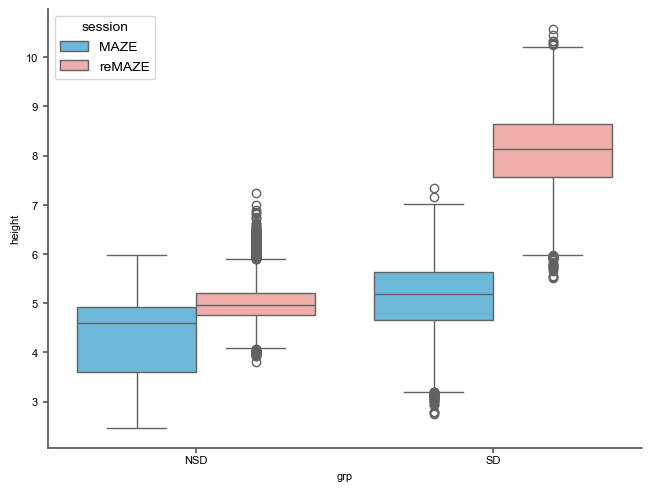

In [13]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
metric = "height"
df_use = trim_unreliable_neurons(stats_all_peak).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_FRpeak_peak_field.csv")
df_bs

### Peak field Plot

/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:2.619e-01 Stat=-6.389e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=-2.966e+00


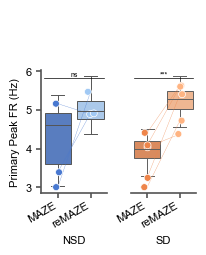

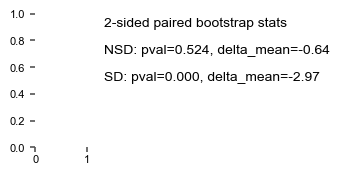

In [19]:
fig = Fig(16, 12)
figs = Fig(16, 12)
metric, mname = "height", "Primary Peak FR (Hz)"

df2_mean = stats_all_peak.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# NSD vs SD
results_list = []
# ax, axstat = axs.T[1]
for ida, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[0:2, ida + 1])
    axrel.append(ax)
    axstat = figs.subplot(figs.gs[2:4, ida + 1])
    axs.append(axstat)
    df_grp = df_bs[df_bs.grp == grp]
    # sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
    #             palette=cmap3[ida*2:], ax=ax)
    # sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
    #               palette=cmap3[ida*2:], ax=ax)
    
    p1 = Plotter(data=df_grp, x="session", y=metric, ax=ax)
    results_list.append(p1.boxplot_remaze(palette=cmap3[ida*2:(ida+1)*2], zorder=3, sep=1.2).stat_anot_remaze(
                stat_within=get_bootstrap_prob_paired,
                alpha_within=[0.025, 0.005, 0.0005],
                alpha_trend=0.05,
                fontsize=5,
                verbose=True,
                prepend=(mname, grp),
            ))
    
    p2 = Plotter(data=df2_mean[df2_mean.grp == grp], x="session", y=metric, ax=ax)
    p2.striplineplot_remaze(palette=cmap3[ida*2:(ida+1)*2], grp_offset=0, dodge=0, units="sid")
    
    if ida == 0:
        ax.set_ylabel(mname)
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    ax.set_xlabel(grp)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
# sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1].set_axis_off()
axrel[0].set_ylim(axrel[1].get_ylim())

fig.savefig(plot_dir / "PF_peakFR_bs.pdf")

#### 2ndary field FR bootstrap

In [20]:
stats_all_peak2 = stats_all_df[stats_all_df.peak_no == 1]

Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 778.17it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:16<00:00, 591.82it/s]


,grp,session,height,metric
0,NSD,MAZE,2.583010,height
1,NSD,MAZE,3.096395,height
2,NSD,MAZE,3.370886,height
3,NSD,MAZE,2.790664,height
4,NSD,MAZE,2.937354,height
...,...,...,...,...
39995,SD,reMAZE,5.077779,height
39996,SD,reMAZE,4.120943,height
39997,SD,reMAZE,5.032957,height
39998,SD,reMAZE,5.591260,height


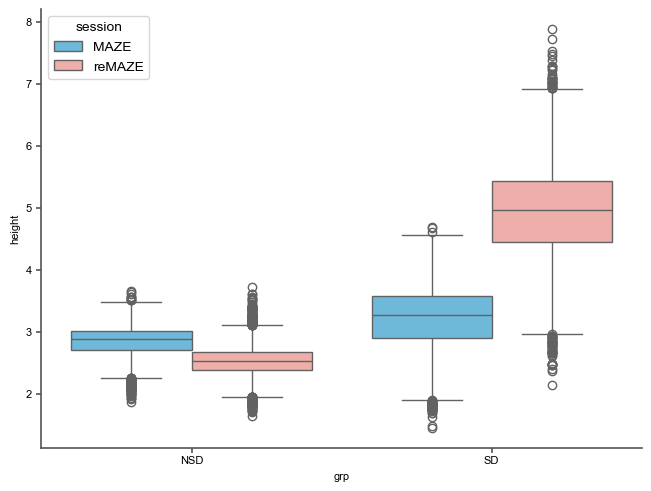

In [21]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean(numeric_only=True).reset_index()
df_bs_all = []
metric = "height"
df_use = trim_unreliable_neurons(stats_all_peak2).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_FRpeak_secondary_field.csv")
df_bs

#### 2ndary field plot

/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:9.420e-02 Stat=3.230e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:7.500e-03 Stat=-1.712e+00


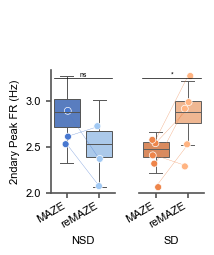

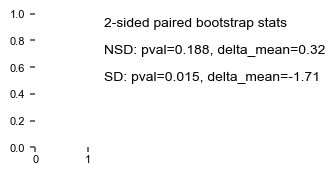

In [24]:
fig = Fig(16, 12)
figs = Fig(16, 12)
metric, mname = "height", "2ndary Peak FR (Hz)"

df2_mean = stats_all_peak2.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# NSD vs SD
# ax, axstat = axs.T[1]
results_list = []
for ida, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[0:2, ida + 1])
    axrel.append(ax)
    axstat = figs.subplot(figs.gs[2:4, ida + 1])
    axs.append(axstat)
    df_grp = df_bs[df_bs.grp == grp]
    # sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
    #             palette=cmap3[ida*2:], ax=ax)
    # sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
    #               palette=cmap3[ida*2:], ax=ax)
    p1 = Plotter(data=df_grp, x="session", y=metric, ax=ax)
    results_list.append(p1.boxplot_remaze(palette=cmap3[ida*2:(ida+1)*2], zorder=3, sep=1.2).stat_anot_remaze(
                stat_within=get_bootstrap_prob_paired,
                alpha_within=[0.025, 0.005, 0.0005],
                alpha_trend=0.05,
                fontsize=5,
                verbose=True,
                prepend=(mname, grp),
            ))
    
    p2 = Plotter(data=df2_mean[df2_mean.grp == grp], x="session", y=metric, ax=ax)
    p2.striplineplot_remaze(palette=cmap3[ida*2:(ida+1)*2], grp_offset=0, dodge=0, units="sid")
    
    if ida == 0:
        ax.set_ylabel(mname)
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    ax.set_xlabel(grp)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
# sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1].set_axis_off()
axrel[0].set_ylim(axrel[1].get_ylim())

fig.savefig(plot_dir / "PF_peakFR_2ndary_bs.pdf")

## # Fields

### Bootstrap # fields

In [8]:
# Calculate # fields
fr_thresh = 4  # only keep fields above this height
fields_keep = ["grp", "sid", "session", "animal", "day", "direction", "cell_id"]
stats_all_df_thresh = stats_all_df[stats_all_df.height > fr_thresh]
nfields_df = stats_all_df_thresh.groupby(fields_keep).count().reset_index().drop(columns=stats_all_df_thresh.columns[~np.isin(stats_all_df_thresh.columns, fields_keep)][1:])
nfields_df = nfields_df.rename(columns={"peak_no": "# fields"})
nfields_df


,grp,sid,session,animal,day,direction,cell_id,# fields
0,NSD,0,MAZE,RatU,Day2,down,11,2
1,NSD,0,MAZE,RatU,Day2,down,15,2
2,NSD,0,MAZE,RatU,Day2,down,19,2
3,NSD,0,MAZE,RatU,Day2,down,21,4
4,NSD,0,MAZE,RatU,Day2,down,34,2
...,...,...,...,...,...,...,...,...
722,SD,7,reMAZE,RatR,Day2,up,38,2
723,SD,7,reMAZE,RatR,Day2,up,39,1
724,SD,7,reMAZE,RatR,Day2,up,46,2
725,SD,7,reMAZE,RatR,Day2,up,52,3


#### NRK NOTE: Below might be unreliable - should not trim out cells that aren't active in both.
Probably should do this BEFORE thresholding with firing rate above!

Running bootstraps for NSD group


100%|████████████████████████████████████████| 10000/10000 [00:12<00:00, 776.04it/s]


Running bootstraps for SD group


100%|████████████████████████████████████████| 10000/10000 [00:17<00:00, 584.34it/s]


,grp,session,# fields,metric
0,NSD,MAZE,1.912371,# fields
1,NSD,MAZE,1.983607,# fields
2,NSD,MAZE,1.882653,# fields
3,NSD,MAZE,1.872449,# fields
4,NSD,MAZE,3.272727,# fields
...,...,...,...,...
39995,SD,reMAZE,1.968421,# fields
39996,SD,reMAZE,1.897959,# fields
39997,SD,reMAZE,2.190840,# fields
39998,SD,reMAZE,2.138298,# fields


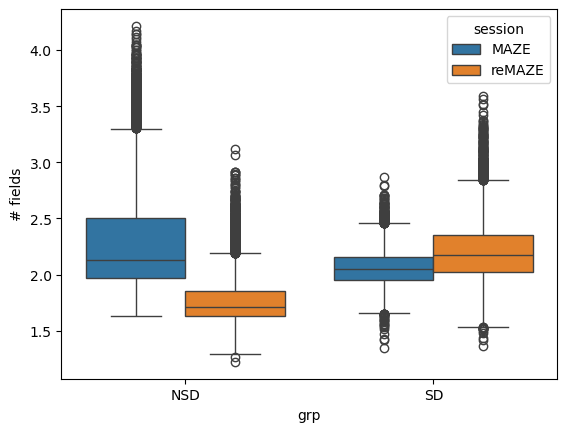

In [12]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
metric = "# fields"
df_use = trim_unreliable_neurons(nfields_df).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / f"pf_nfields_pf_thresh{fr_thresh}_bs.csv")
df_bs

In [22]:
df_trim = df_bs[df_bs.metric == "# fields"]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    print(f"{grp} bootstrap p-value={pval}")

NSD bootstrap p-value=9.999999999998899e-05
SD bootstrap p-value=0.3037


### Plot # fields

/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:6.000e-04 Stat=5.308e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:3.002e-01 Stat=-1.429e-01


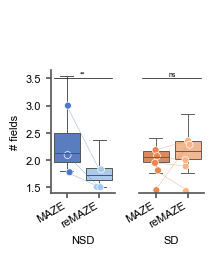

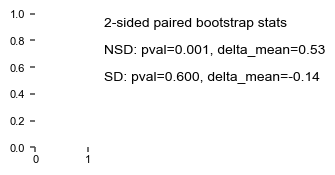

In [15]:
from neuropy.utils.plot_util import match_axis_lims
fig = Fig(16, 12)
figs = Fig(16, 12)
metric, mname = "# fields", "# fields"

# axs[0, 0].set_axis_off()

df2_mean = nfields_df.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# NSD vs SD
# ax, axstat = axs.T[1]
results_list = []
axrel, axs = [], []
for ida, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[0:2, ida + 1])
    axrel.append(ax)
    axstat = figs.subplot(figs.gs[2:4, ida + 1])
    axs.append(axstat)
    df_grp = df_bs[df_bs.grp == grp]
    # sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
    #             palette=cmap3[ida*2:], ax=ax)
    # sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
    #               palette=cmap3[ida*2:], ax=ax)
    p1 = Plotter(data=df_grp, x="session", y=metric, ax=ax)
    results_list.append(p1.boxplot_remaze(palette=cmap3[ida*2:(ida+1)*2], zorder=3, sep=1.2).stat_anot_remaze(
                stat_within=get_bootstrap_prob_paired,
                alpha_within=[0.025, 0.005, 0.0005],
                alpha_trend=0.05,
                fontsize=5,
                verbose=True,
                prepend=(mname, grp),
            ))
    
    p2 = Plotter(data=df2_mean[df2_mean.grp == grp], x="session", y=metric, ax=ax)
    p2.striplineplot_remaze(palette=cmap3[ida*2:(ida+1)*2], grp_offset=0, dodge=0, units="sid")
    
    if ida == 0:
        ax.set_ylabel(mname)
        # ax.set_xticklabels([grp])
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    ax.set_xlabel(grp)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1].set_axis_off()
# match_axis_lims(axrel, "y")
axrel[1].set_ylim(axrel[0].get_ylim())

fig.savefig(plot_dir / f"PF_nfields_frthresh{fr_thresh}_bs.pdf")

## NRK TODO
Run # fields analysis with a better threshold, e.g. # peaks above a certain firing rate or within 50% of the peak FR?  Look at literature to determine # fields.